In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from torch import optim

In [2]:
from library.dataset import get_pytorch_datataset, BATCH_SIZE

df_returns_real, dataset, dataloader, N_ASSETS, WINDOW_SIZE = get_pytorch_datataset()

print(f'\nDataset length: {len(dataset)}')
print(f'Number of assets: {N_ASSETS}')
sample_batch = next(iter(dataloader))
assert sample_batch.size() == (BATCH_SIZE, N_ASSETS, WINDOW_SIZE)
print(f'Sample batch: {sample_batch.size()}')

Chosen tickers: ['SBER', 'LKOH', 'SBERP', 'VTBR', 'MOEX']
Length before dropping NaNs: 2989
Length after dropping NaNs: 2959

Dataset length: 2833
Number of assets: 5
Sample batch: torch.Size([256, 5, 126])


In [3]:
df_returns_real=df_returns_real[:-252]

In [4]:
from library.gan import Discriminator, Generator
from library.constants import DEVICE
assert Discriminator()(next(iter(dataloader))).size() == (BATCH_SIZE,)
assert Generator()(Generator.get_noise(BATCH_SIZE)).size() == next(iter(dataloader)).size()


/Users/nikolajgudkov/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [5]:

from library.generation import generate_fake_returns
from library.gan_train_loop import load_gan

generator = Generator().to(DEVICE)
load_gan('TCN', generator, epoch=50)
df_returns_fake = generate_fake_returns(generator, df_returns_real, seed=0)
 

Load 50 epoch checkpoint


<Axes: xlabel='date'>

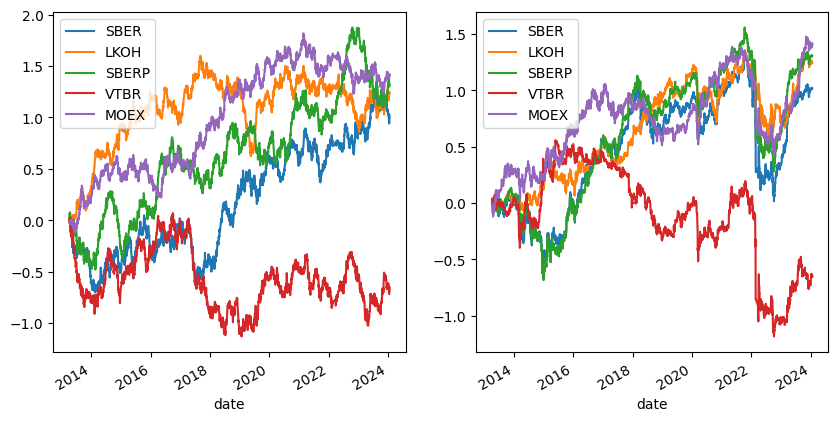

In [6]:
fig, axes = plt.subplots(1,2, figsize=(10,5))

df_returns_fake.cumsum().plot(ax=axes[0])

df_returns_real.cumsum().plot(ax=axes[1])

In [7]:
df_returns_real.columns[0]

'SBER'

In [8]:
from library.momentum import get_momentum_signal

In [9]:
n_finish=360
n_start=180

real_momentum_series=get_momentum_signal(df_returns_real,n_finish=n_finish,n_start=n_start)
fake_momentum_series=get_momentum_signal(df_returns_fake,n_finish=n_finish,n_start=n_start)

In [18]:
import numpy as np

def calculate_acd(x, y, k):
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]

    assert len(x) == len(y)
    # Функция для расчета автокорреляции
    def autocorr(x, lag):
        return np.corrcoef(np.array([x[:-lag], x[lag:]]))[0][1]
    
    # Рассчитываем автокорреляцию для обоих рядов
    rho_x = autocorr(x, k)
    rho_y = autocorr(y, k)
    
    # Возвращаем абсолютную разность автокорреляций
    return np.abs(rho_x - rho_y)

In [28]:
import warnings
warnings.filterwarnings('ignore')

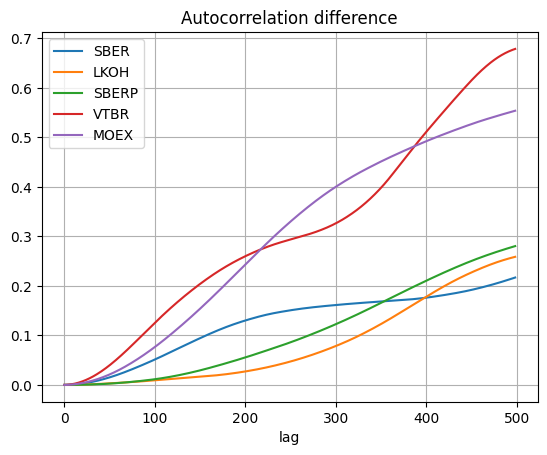

In [35]:
acd = {}
for asset in df_returns_real.columns:
    acd[asset] = []
    for k in range(1, 500):
        acd[asset].append(calculate_acd(real_momentum_series[asset].cumsum(), fake_momentum_series[asset].cumsum(), k))
    plt.plot(acd[asset], label=asset)

plt.legend()
plt.grid()
plt.title("Autocorrelation difference")
plt.xlabel("lag")

plt.show()

Чтобы оценить график в целом, будем брать площадь под кривой. посмотрим как эти площади меняются с течением обучения

In [31]:
def calculate_area(y_values, delta_x=1.0):
  """
  Вычисляет площадь под графиком, заданным массивом значений y,
  при фиксированном расстоянии между точками по x.

  Args:
    y_values: Список значений y.
    delta_x: Расстояние между точками по x.  По умолчанию равно 1.0.

  Returns:
    Площадь под графиком.
  """

  area = 0.0
  for i in range(len(y_values) - 1):
    y1 = y_values[i]
    y2 = y_values[i + 1]
    area += delta_x * (y1 + y2) / 2.0  # Площадь трапеции

  return area



Load 1 epoch checkpoint
Load 800 epoch checkpoint
Load 200 epoch checkpoint
Load 600 epoch checkpoint
Load 50 epoch checkpoint
Load 400 epoch checkpoint


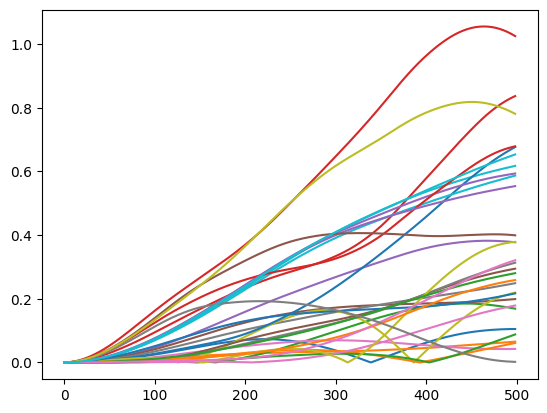

In [38]:
import os
areas = {}
for asset in df_returns_real.columns:
    areas[asset] = []
for filename in os.listdir('models/TCN'):
    epoch_num = int(filename.split('_')[-1])
    load_gan('TCN', generator, epoch=epoch_num)
    df_returns_fake = generate_fake_returns(generator, df_returns_real, seed=0)
    fake_momentum_series=get_momentum_signal(df_returns_fake,n_finish=n_finish,n_start=n_start)
    for asset in df_returns_real.columns:
        acd = {}    
        acd[asset] = []
        for k in range(1, 500):
            acd[asset].append(calculate_acd(real_momentum_series[asset].cumsum(), fake_momentum_series[asset].cumsum(), k))
        dif_series = acd[asset]
        area = calculate_area(dif_series)
        areas[asset].append((epoch_num, area)) 

In [41]:
area

157.1604405042179

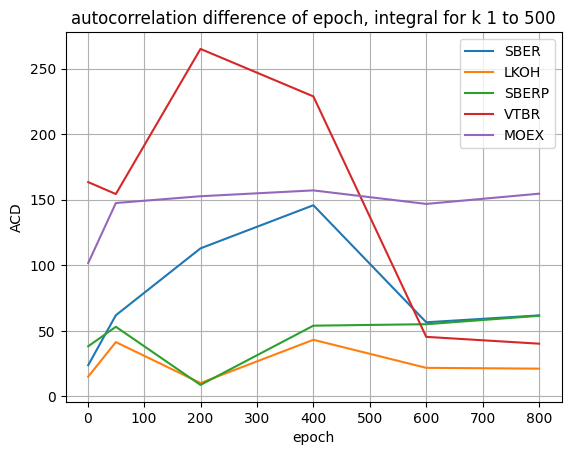

In [48]:
for asset in df_returns_real.columns:
    sorted_areas = sorted(areas[asset])
    x = [a[0] for a in sorted_areas]
    y = [a[1] for a in sorted_areas]
    plt.plot(x, y, label=asset)

plt.grid()
plt.legend()
plt.title("autocorrelation difference of epoch, integral for k 1 to 500")
plt.ylabel("ACD")
plt.xlabel("epoch")
plt.show()

In [212]:
import torch
import json

# Загрузка гиперпараметров
with open('CricketX_hyperparameters.json', 'r') as f:
    hyperparams = json.load(f)

hyperparams

{'compared_length': inf,
 'nb_random_samples': 5,
 'negative_penalty': 1,
 'batch_size': 10,
 'nb_steps': 1500,
 'lr': 0.001,
 'penalty': None,
 'early_stopping': None,
 'channels': 40,
 'depth': 10,
 'reduced_size': 160,
 'kernel_size': 3,
 'in_channels': 1,
 'out_channels': 320,
 'cuda': True,
 'gpu': 2}

In [217]:
from causal_cnn import CausalCNNEncoder

In [224]:
import torch
import torch.nn as nn


cnn_hyperparams = {
    'in_channels': hyperparams['in_channels'],
    'channels': hyperparams['channels'],
    'depth': hyperparams['depth'],
    'out_channels': hyperparams['out_channels'],
    'kernel_size': hyperparams['kernel_size'],
    'reduced_size': 160
}

# Создание модели
model = CausalCNNEncoder(**cnn_hyperparams)


# Загрузка весов
model.load_state_dict(torch.load('CricketX_CausalCNN_encoder.pth', map_location=device))
model.eval();

In [237]:
real_momentum_series.cumsum()[~mask]

,SBER,LKOH,SBERP,VTBR,MOEX
date,,,,,
2013-05-03,0.000000,0.000000,0.000000,0.000000,0.000000
2013-05-06,0.000000,0.000000,0.000000,0.000000,0.000000
2013-05-07,0.000000,0.000000,0.000000,0.000000,0.000000
2013-05-08,0.000000,0.000000,0.000000,0.000000,0.000000
2013-05-10,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2024-01-17,90.707794,105.446050,124.747669,-117.141315,105.989055
2024-01-18,91.171794,105.772312,125.224251,-116.826869,106.204261
2024-01-19,91.641282,106.106153,125.707996,-116.498654,106.411632


In [261]:
torch.tensor(real_data.values, dtype=torch.float32).unsqueeze(0).unsqueeze(0).unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 1, 1, 2687, 5])

In [262]:
import torch
import pandas as pd
from causal_cnn import CausalCNNEncoder

# Гиперпараметры
hyperparams = {
    'in_channels': 1,
    'channels': 40,
    'depth': 10,
    'reduced_size': 160,
    'out_channels': 320,
    'kernel_size': 3
}

# Создание модели
model = CausalCNNEncoder(**hyperparams)

# Пример данных: 5 временных рядов, каждый длиной 2685 и с 1 каналом
real_data_list = [real_momentum_series[asset].cumsum()[~mask] for asset in real_momentum_series.columns]  # Список из 5 временных рядов
generated_data_list = [fake_momentum_series[asset].cumsum()[~mask] for asset in real_momentum_series.columns]  # Список из 5 временных рядов

# Преобразование в тензоры
real_data_tensors = [torch.tensor(data.values, dtype=torch.float32).unsqueeze(0) for data in real_data_list]
generated_data_tensors = [torch.tensor(data.values, dtype=torch.float32).unsqueeze(0) for data in generated_data_list]

# Конкатенация в один батч
real_data_batch = torch.cat(real_data_tensors, dim=0).unsqueeze(1)  # (5, 1, 2685)
generated_data_batch = torch.cat(generated_data_tensors, dim=0).unsqueeze(1)  # (5, 1, 2685)

# Пропуск данных через модель
real_features = model(real_data_batch)  # real_features shape: (5, 320)
generated_features = model(generated_data_batch)  # generated_features shape: (5, 320)

print("Real features shape:", real_features.shape)
print("Generated features shape:", generated_features.shape)

Real features shape: torch.Size([5, 320])
Generated features shape: torch.Size([5, 320])


In [263]:
print(real_features.shape)
print(generated_features.shape)

torch.Size([5, 320])
torch.Size([5, 320])


In [275]:
import numpy as np
from scipy.linalg import sqrtm

def calculate_fid(real_features, generated_features):
    # Вычисление средних значений
    mu_real = np.mean(real_features, axis=0)
    mu_gen = np.mean(generated_features, axis=0)

    # Вычисление ковариационных матриц
    sigma_real = np.cov(real_features, rowvar=False)
    sigma_gen = np.cov(generated_features, rowvar=False)

    # Разность средних
    diff = mu_real - mu_gen

    # Квадратный корень произведения ковариационных матриц
    covmean = sqrtm(sigma_real.dot(sigma_gen))
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Расчет Fréchet Distance
    fid = diff.dot(diff) + np.trace(sigma_real + sigma_gen - 2 * covmean)
    return fid

real_features_np = real_features.detach().numpy()
generated_features_np = generated_features.detach().numpy()

# Расчет C-FID
cfid_score = calculate_fid(real_features_np, generated_features_np)
print("C-FID score:", cfid_score)

C-FID score: 47863.20033936498


In [284]:
import os
fids = {}
for filename in os.listdir('models/TCN'):
    epoch_num = int(filename.split('_')[-1])
    load_gan('TCN', generator, epoch=epoch_num)
    df_returns_fake = generate_fake_returns(generator, df_returns_real, seed=0)
    mask = np.isnan(real_momentum_series[asset].cumsum())
    
    fake_momentum_series=get_momentum_signal(df_returns_fake,n_finish=n_finish,n_start=n_start)
    
    # Пример данных: 5 временных рядов, каждый длиной 2685 и с 1 каналом
    real_data_list = [real_momentum_series[asset].cumsum()[~mask] for asset in real_momentum_series.columns]  # Список из 5 временных рядов
    generated_data_list = [fake_momentum_series[asset].cumsum()[~mask] for asset in fake_momentum_series.columns]  # Список из 5 временных рядов
    
    # Преобразование в тензоры
    real_data_tensors = [torch.tensor(data.values, dtype=torch.float32).unsqueeze(0) for data in real_data_list]
    generated_data_tensors = [torch.tensor(data.values, dtype=torch.float32).unsqueeze(0) for data in generated_data_list]
    
    # Конкатенация в один батч
    real_data_batch = torch.cat(real_data_tensors, dim=0).unsqueeze(1)  # (5, 1, 2685)
    generated_data_batch = torch.cat(generated_data_tensors, dim=0).unsqueeze(1)  # (5, 1, 2685)
    
    # Пропуск данных через модель
    real_features = model(real_data_batch)  # real_features shape: (5, 320)
    generated_features = model(generated_data_batch)  # generated_features shape: (5, 320)

    real_features_np = real_features.detach().numpy()
    generated_features_np = generated_features.detach().numpy()

    # Расчет C-FID
    cfid_score = calculate_fid(real_features_np, generated_features_np)

    fids[epoch_num] = cfid_score

Load 1 epoch checkpoint
Load 800 epoch checkpoint
Load 200 epoch checkpoint
Load 600 epoch checkpoint
Load 50 epoch checkpoint
Load 400 epoch checkpoint


In [290]:
fids

{1: 1909487423794.1946,
 800: 11215049.201011147,
 200: 73046255.17348398,
 600: 2044842.3687206546,
 50: 14683590208.63209,
 400: 1113097.69852651}

In [289]:
sorted_fids

[1, 50, 200, 400, 600, 800]

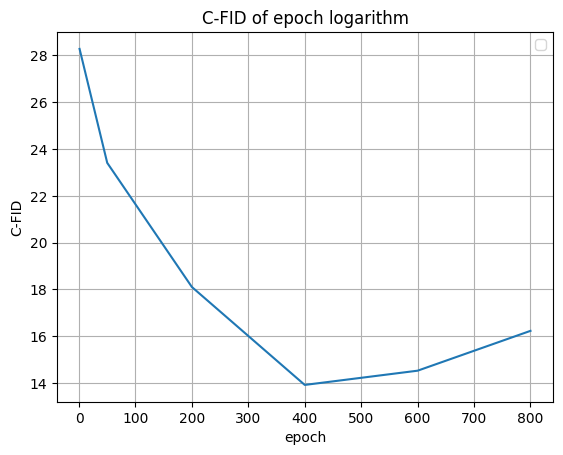

In [294]:

sorted_fids = sorted(fids)
x = [a for a in sorted_fids]
y = [fids[a] for a in sorted_fids]
plt.plot(x, np.log(y))

plt.grid()
plt.legend()
plt.title("C-FID of epoch logarithm")
plt.ylabel("C-FID")
plt.xlabel("epoch")
plt.show()

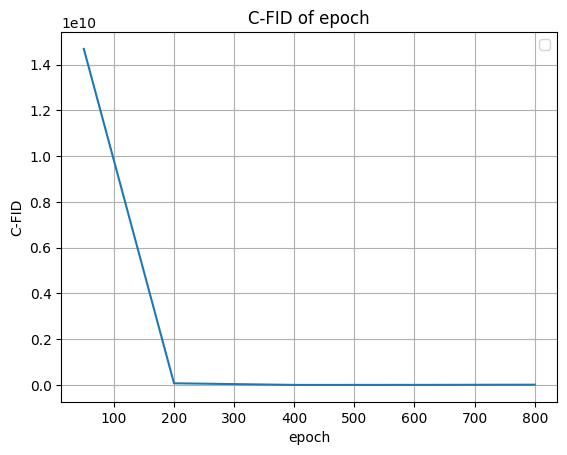

In [292]:

sorted_fids = sorted(fids)
x = [a for a in sorted_fids]
y = [fids[a] for a in sorted_fids]
plt.plot(x[1:], y[1:])

plt.grid()
plt.legend()
plt.title("C-FID of epoch")
plt.ylabel("C-FID")
plt.xlabel("epoch")
plt.show()